# 1. 데이터 로드

In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building_info = pd.read_csv('building_info.csv')

train = pd.merge(train, building_info, on='건물번호', how='left')
test = pd.merge(test, building_info, on='건물번호', how='left')

print("데이터 병합 완료!")
print(f"병합 후 train 데이터 모양: {train.shape}")

print("\n--- Train 데이터 결측치 상태 ---")
print(train.isnull().sum())

데이터 병합 완료!
병합 후 train 데이터 모양: (204000, 16)

--- Train 데이터 결측치 상태 ---
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
건물유형             0
연면적(m2)          0
냉방면적(m2)         0
태양광용량(kW)        0
ESS저장용량(kWh)     0
PCS용량(kW)        0
dtype: int64


# 2. EDA - 데이터 분석

In [4]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train.sample(20000, random_state=42), title="Energy Consumption Profiling Report")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 108.24it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.1 상관관계가 높은 PCS, ESS / 일조, 일사, 습도 비교

In [5]:
import pandas as pd
import numpy as np

# 1. 대상 컬럼 정의 (에러 방지를 위해 명시적으로 정의)
building_cols = ['연면적(m2)', '냉방면적(m2)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
weather_cols = ['습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
cols_to_fix = building_cols # NameError 방지용

# 2. building_info 데이터 타입 수리 (문자열 '-' 제거 및 숫자 변환)
for col in building_cols:
    if col in building_info.columns:
        # 하이픈 제거 -> 숫자 변환 -> 결측치 0 채움
        building_info[col] = pd.to_numeric(building_info[col].replace('-', np.nan), errors='coerce').fillna(0)

# 3. train 데이터 타입 수리
for col in weather_cols:
    if col in train.columns:
        # 하이픈 제거 -> 숫자 변환 -> 선형 보간으로 결측치 채움
        train[col] = pd.to_numeric(train[col].replace('-', np.nan), errors='coerce')
        train[col] = train[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

print("✅ 데이터 타입 수리 및 결측치 처리 완료!")

# 4. 건물 제원 상관계수 출력
building_corr_sub = building_info[building_cols].corr()
print("\n=== [건물 제원] 상관계수 상세 수치 ===")
print(building_corr_sub)
print(f"\n1. 연면적 vs 냉방면적: {building_corr_sub.loc['연면적(m2)', '냉방면적(m2)']:.4f}")
print(f"2. ESS용량 vs PCS용량: {building_corr_sub.loc['ESS저장용량(kWh)', 'PCS용량(kW)']:.4f}")

# 5. 기상/소비 상관계수 출력
weather_corr_sub = train[weather_cols].corr()
print("\n=== [기상/소비] 상관계수 상세 수치 ===")
print(f"3. 습도 vs 일조량: {weather_corr_sub.loc['습도(%)', '일조(hr)']:.4f}")
print(f"4. 습도 vs 일사량: {weather_corr_sub.loc['습도(%)', '일사(MJ/m2)']:.4f}")

✅ 데이터 타입 수리 및 결측치 처리 완료!

=== [건물 제원] 상관계수 상세 수치 ===
               연면적(m2)  냉방면적(m2)  ESS저장용량(kWh)  PCS용량(kW)
연면적(m2)       1.000000  0.967982      0.001898   0.002551
냉방면적(m2)      0.967982  1.000000     -0.012885  -0.017847
ESS저장용량(kWh)  0.001898 -0.012885      1.000000   0.962355
PCS용량(kW)     0.002551 -0.017847      0.962355   1.000000

1. 연면적 vs 냉방면적: 0.9680
2. ESS용량 vs PCS용량: 0.9624

=== [기상/소비] 상관계수 상세 수치 ===
3. 습도 vs 일조량: -0.6417
4. 습도 vs 일사량: -0.5902


/var/folders/jp/184w34_s3399yx_81b84g5f00000gn/T/ipykernel_4107/4253729530.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[col] = train[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


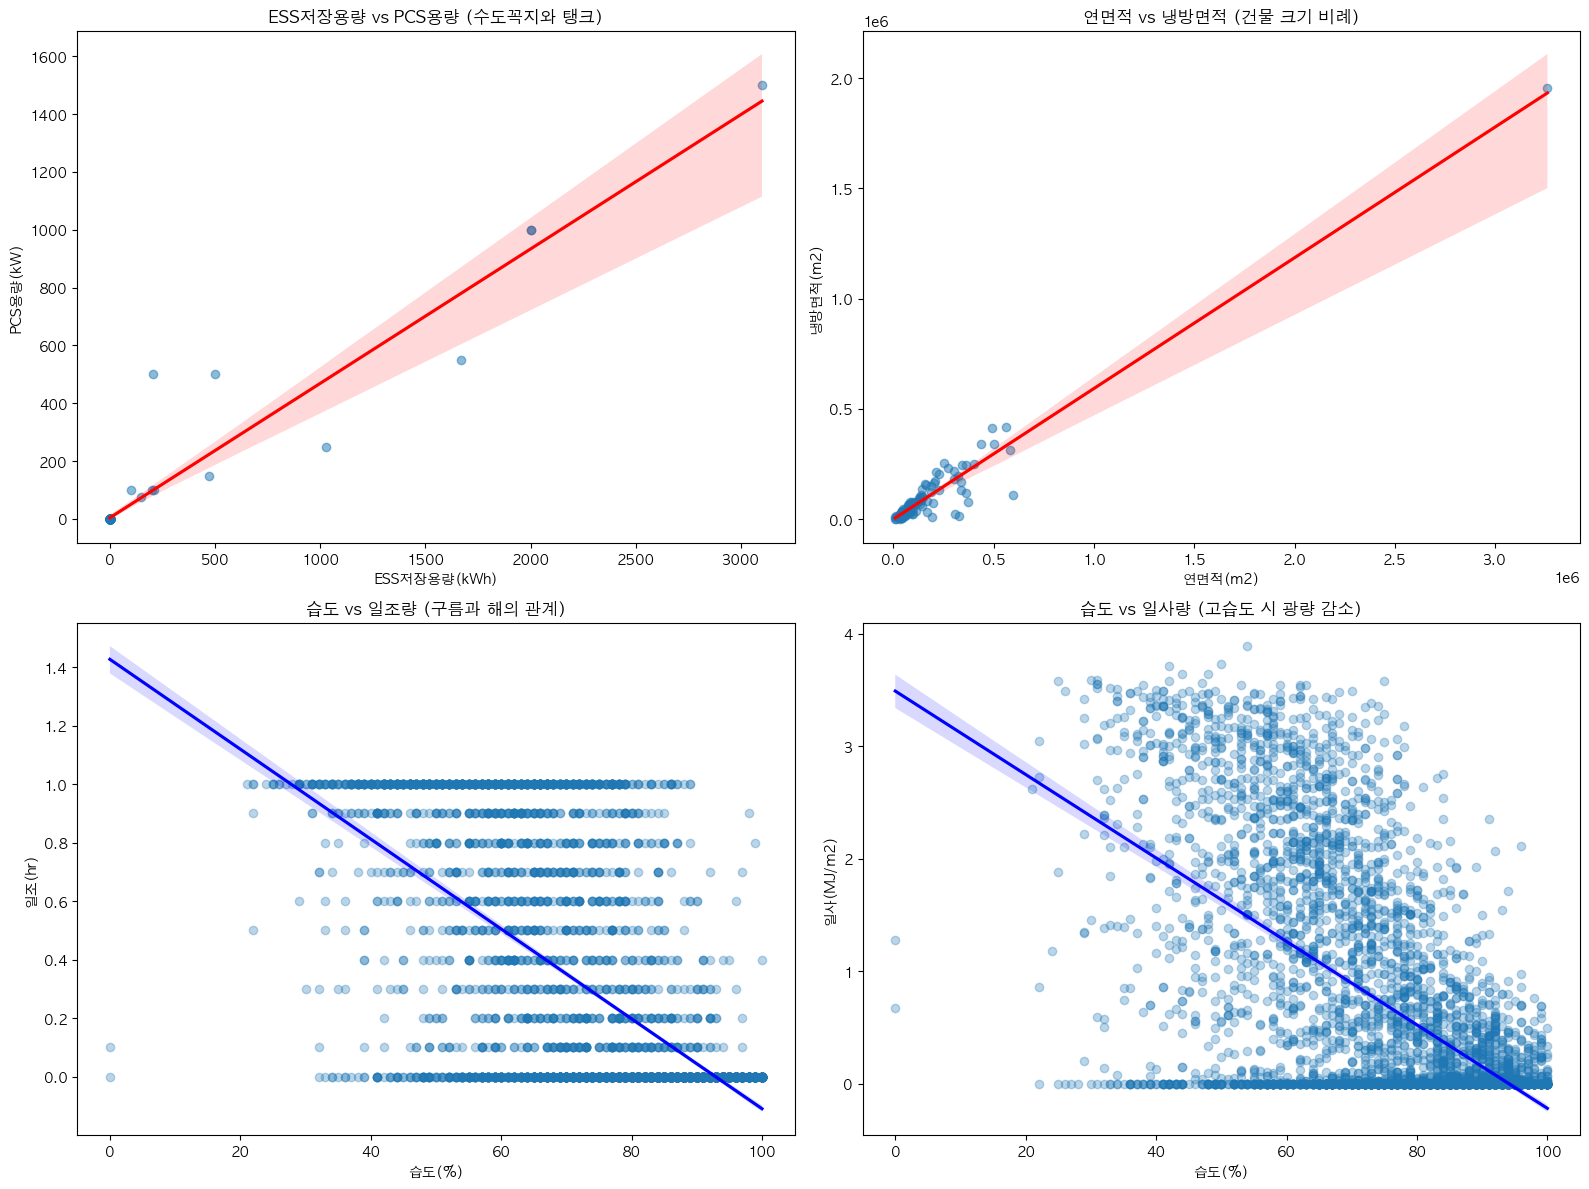

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 맥(Mac) 전용 한글 폰트 설정 및 초기화
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 2. 서윤님의 가설 검증을 위한 4가지 핵심 그래프
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (1) ESS저장용량 vs PCS용량 (상관계수 ~1.0)
sns.regplot(x='ESS저장용량(kWh)', y='PCS용량(kW)', data=building_info, ax=axes[0, 0], 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title('ESS저장용량 vs PCS용량 (수도꼭지와 탱크)')

# (2) 연면적 vs 냉방면적 (상관계수 ~0.96)
sns.regplot(x='연면적(m2)', y='냉방면적(m2)', data=building_info, ax=axes[0, 1], 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title('연면적 vs 냉방면적 (건물 크기 비례)')

# (3) 습도 vs 일조량 (음의 상관관계)
# 데이터가 많으므로 5000개만 샘플링해서 가독성을 높입니다.
sample_train = train.sample(5000, random_state=42)
sns.regplot(x='습도(%)', y='일조(hr)', data=sample_train, ax=axes[1, 0], 
            scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
axes[1, 0].set_title('습도 vs 일조량 (구름과 해의 관계)')

# (4) 습도 vs 일사량 (음의 상관관계)
sns.regplot(x='습도(%)', y='일사(MJ/m2)', data=sample_train, ax=axes[1, 1], 
            scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
axes[1, 1].set_title('습도 vs 일사량 (고습도 시 광량 감소)')

plt.tight_layout()
plt.show()

## 2.2 건물 유형별 시간당 평균 전력 소비 패턴 확인

현재 데이터 컬럼: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'hour']


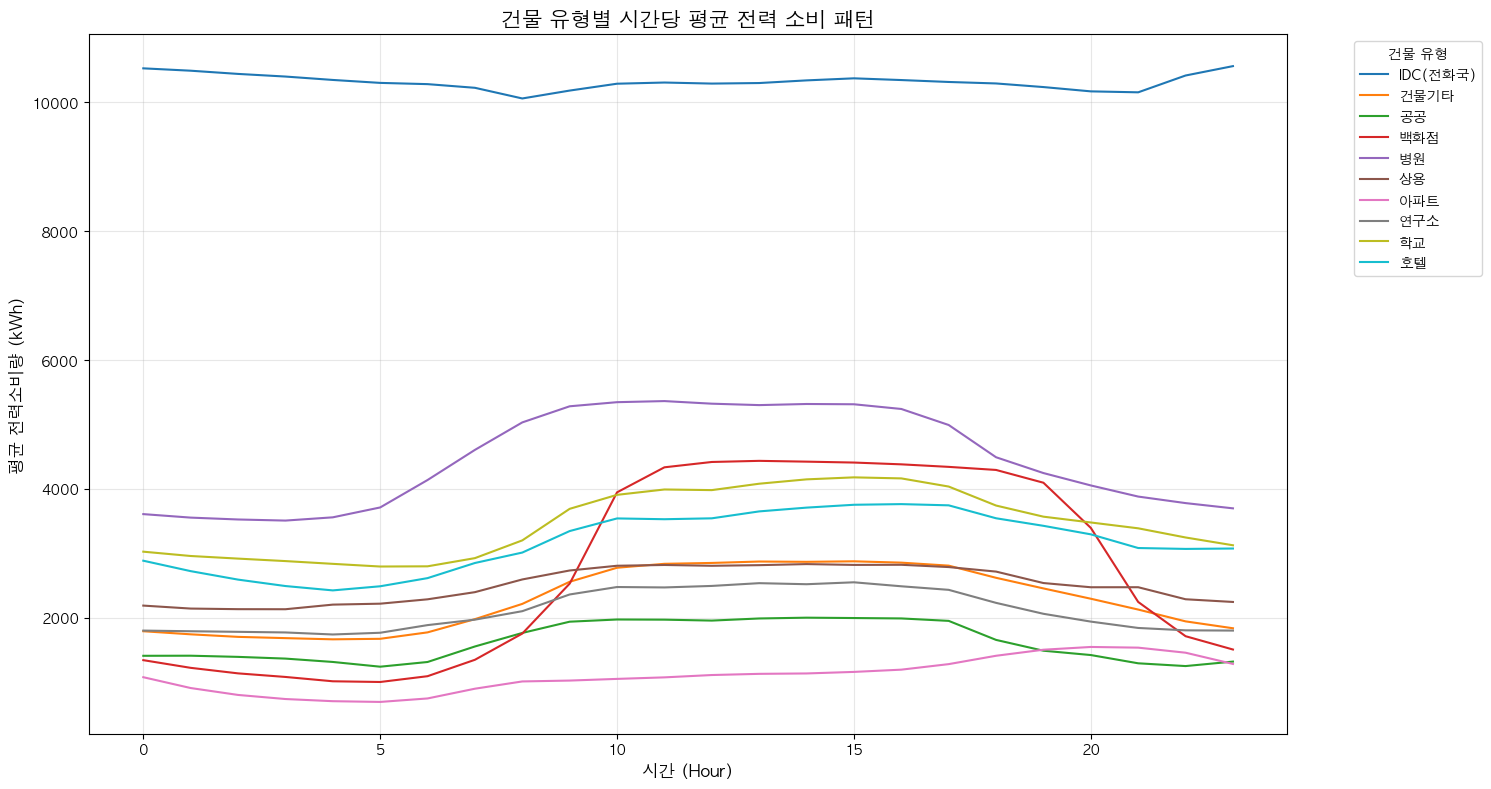

In [7]:
# 1. '일시' 컬럼을 datetime 형식으로 변환 (이미 되어있다면 통과)
train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d %H')

# 2. 그래프를 그리기 위한 'hour' 컬럼 생성
if 'hour' not in train.columns:
    train['hour'] = train['일시'].dt.hour

# 3. '건물유형'이 잘 들어있는지 확인
print("현재 데이터 컬럼:", train.columns.tolist())

# 4. 이제 다시 시각화 시도
pivot_df = train.groupby(['hour', '건물유형'])['전력소비량(kWh)'].mean().unstack()

# (이후 시각화 코드 계속...)

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 건물 유형별 시간당 평균 전력 소비량 계산
pivot_df = train.groupby(['hour', '건물유형'])['전력소비량(kWh)'].mean().unstack()

# 그래프 그리기
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_df, dashes=False)
plt.title('건물 유형별 시간당 평균 전력 소비 패턴', fontsize=15)
plt.xlabel('시간 (Hour)', fontsize=12)
plt.ylabel('평균 전력소비량 (kWh)', fontsize=12)
plt.legend(title='건물 유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.3 요일성 영향도 확인 - to_datetime 변수 쪼개는 방향성 설정을 위해

/var/folders/jp/184w34_s3399yx_81b84g5f00000gn/T/ipykernel_4107/996861242.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = pd.to_numeric(df[col]).interpolate().fillna(method='ffill').fillna(method='bfill')


✅ 시각화 및 모델 학습을 위한 모든 변수(hour, weekday, is_weekend, 불쾌지수) 준비 완료!


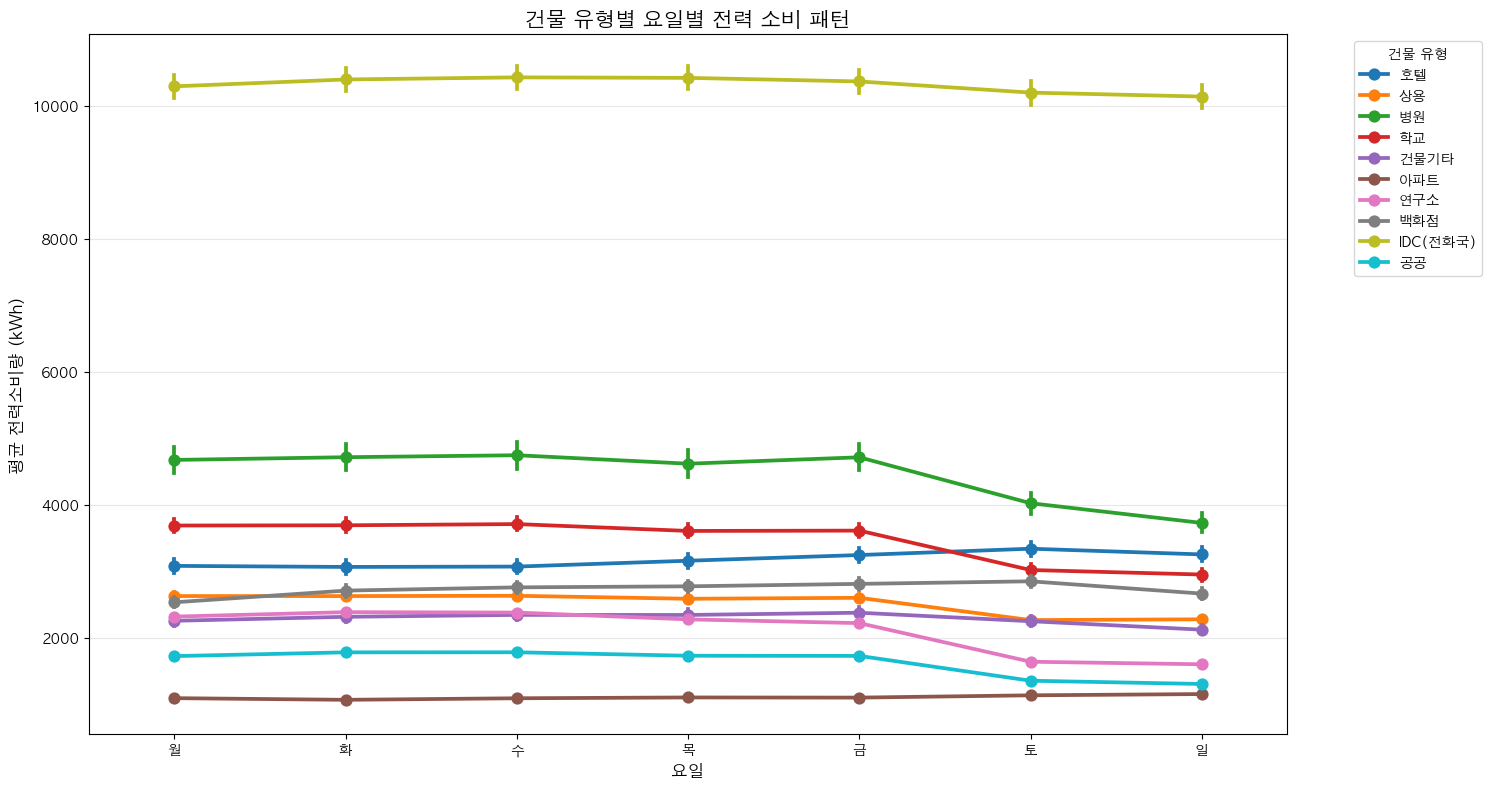

In [8]:
import pandas as pd
import numpy as np

# 1. '일시' 컬럼을 datetime 형식으로 변환 (Train/Test 공통)
for df in [train, test]:
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    
    # 2. 시간 관련 변수 생성
    df['month'] = df['일시'].dt.month
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday # 0:월 ~ 6:일
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# 3. 불쾌지수 생성 (연구소 필살기!)
for df in [train, test]:
    df['불쾌지수'] = 0.81 * df['기온(°C)'] + 0.01 * df['습도(%)'] * (0.99 * df['기온(°C)'] - 14.3) + 46.3

# 4. 결측치/하이픈 처리 (중요!)
for df in [train, test]:
    df.replace('-', np.nan, inplace=True)
    # 강수량 0 처리
    if '강수량(mm)' in df.columns:
        df['강수량(mm)'] = pd.to_numeric(df['강수량(mm)']).fillna(0)
    # 나머지 기상 데이터 보간
    cols_to_fill = ['기온(°C)', '풍속(m/s)', '습도(%)']
    for col in cols_to_fill:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col]).interpolate().fillna(method='ffill').fillna(method='bfill')

print("✅ 시각화 및 모델 학습을 위한 모든 변수(hour, weekday, is_weekend, 불쾌지수) 준비 완료!")

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 시각화 설정 (맥용 한글 폰트)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 2. 요일별/건물유형별 평균 전력소비량 계산
# weekday: 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일)
day_order = [0, 1, 2, 3, 4, 5, 6]
day_labels = ['월', '화', '수', '목', '금', '토', '일']

plt.figure(figsize=(15, 8))
sns.pointplot(x='weekday', y='전력소비량(kWh)', hue='건물유형', data=train, 
              order=day_order, markers='o', linestyles='-')

plt.title('건물 유형별 요일별 전력 소비 패턴', fontsize=15)
plt.xticks(day_order, day_labels)
plt.xlabel('요일', fontsize=12)
plt.ylabel('평균 전력소비량 (kWh)', fontsize=12)
plt.legend(title='건물 유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. 데이터 전처리

In [9]:
# 일사량 데이터가 train에만 있어서 있는 데이터들로 예측해서 test도 채워넣기

from lightgbm import LGBMRegressor
import numpy as np

# 1. 일사량 예측을 위한 피처 선정 (일사와 관계 깊은 변수들)
insolation_features = ['기온(°C)', '습도(%)', '풍속(m/s)', 'month', 'hour']

# 2. train 데이터에서 일사량이 있는 행들로 학습 데이터 구성
# (일사량이 0인 밤 시간대 데이터도 포함하여 패턴을 학습합니다)
X_insolation_train = train[insolation_features]
y_insolation_train = train['일사(MJ/m2)']

# 3. 일사량 예측 모델 생성 및 학습
model_insolation = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model_insolation.fit(X_insolation_train, y_insolation_train)

# 4. test 데이터의 일사량 예측하여 채우기
test['일사(MJ/m2)'] = model_insolation.predict(test[insolation_features])

# 5. (물리적 제약 조건) 일사량은 음수가 될 수 없으므로 0 이하는 0으로 처리
test['일사(MJ/m2)'] = test['일사(MJ/m2)'].apply(lambda x: x if x > 0 else 0)

print("Virtual Sensor: test 데이터의 일사량 예측 완료!")
print(test[['일시', '일사(MJ/m2)']].head())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 204000, number of used features: 5
[LightGBM] [Info] Start training from score 0.702752
Virtual Sensor: test 데이터의 일사량 예측 완료!
                   일시  일사(MJ/m2)
0 2024-08-25 00:00:00        0.0
1 2024-08-25 01:00:00        0.0
2 2024-08-25 02:00:00        0.0
3 2024-08-25 03:00:00        0.0
4 2024-08-25 04:00:00        0.0


In [10]:
# 실제 예측되어 값이 들어간지 확인

sample_data = test[test['일사(MJ/m2)'] > 0][['일시', 'hour', '일사(MJ/m2)']].sample(10)
print("--- 일사가 발생한 시간대의 예측값 확인 ---")
print(sample_data.sort_values(by='일시'))

--- 일사가 발생한 시간대의 예측값 확인 ---
                       일시  hour  일사(MJ/m2)
8243  2024-08-25 11:00:00    11   1.644312
10975 2024-08-27 07:00:00     7   0.088580
1069  2024-08-27 13:00:00    13   1.601640
1423  2024-08-28 07:00:00     7   0.135506
12863 2024-08-28 23:00:00    23   0.000230
4976  2024-08-29 08:00:00     8   0.825859
14742 2024-08-30 06:00:00     6   0.004052
6679  2024-08-30 07:00:00     7   0.291643
3016  2024-08-31 16:00:00    16   2.044031
15618 2024-08-31 18:00:00    18   0.363433


In [11]:
# 일사량 예측은 둔감한 사람들을 위해서 넣음 (온도,습도를 보고 괜찮은 수준이네 판단)
# 예민한 사람들은 자기 신체 데이터에 따라 온도 변경하기 때문에 이들을 위한 불쾌지수 생성 (기상청 사용 수식 차용)

for df in [train, test]:
    df['불쾌지수'] = 0.81 * df['기온(°C)'] + 0.01 * df['습도(%)'] * (0.99 * df['기온(°C)'] - 14.3) + 46.3

In [12]:
# 일조로 태양광 발전이 일어나, ESS로 들어가고 PCS로 결국 아웃풋을 만들기 때문에 세 팩터는 PCS로 압축
# 일사는 태양 에너지가 지표에 닿는 수준이므로 소비를 만드는 범인으로 남김
# 연면적과 냉방면적이 많이 다르면 냉방면적에만 전원이 공급되지만, 냉방이 공급되지 않는 연면적 부분과도 에너지 교환이 일어나 소비를 늘릴 것임. 하지만 둘 관계가 0.96이상이므로 냉방면적만 남김
# to_datetime 항목은 계절성 확인을 위한 달구분, 주중/주말 상황변환을 파악하기 위한 구분, 일사량 차이 파악을 위한 시간대별 구분으로 분류

import pandas as pd

train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d %H')
test['일시'] = pd.to_datetime(test['일시'], format='%Y%m%d %H')

for df in [train, test]:
    df['month'] = df['일시'].dt.month      # 4계절 특성 반영
    df['hour'] = df['일시'].dt.hour        # 일사량 및 일과 시간 반영
    df['weekday'] = df['일시'].dt.weekday  # 요일별 특성 (0:월 ~ 6:일)
    # 주말/주중 구분 (손님 방문 차이 반영: 토/일은 1, 평일은 0)
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

final_features = [
    '건물번호', '건물유형', '냉방면적(m2)', 'PCS용량(kW)', 
    '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', 
    '불쾌지수', 'month', 'hour', 'is_weekend' 
]

# 학습용(X)과 타겟(y) 데이터 분리
X_train = train[final_features]
y_train = train['전력소비량(kWh)']
X_test = test[final_features]

print("--- 시간 데이터 분리 및 피처 선정 완료 ---")
print(X_train[['month', 'hour', 'is_weekend']].head())
print(f"\n최종 사용할 변수: {X_train.columns.tolist()}")

--- 시간 데이터 분리 및 피처 선정 완료 ---
   month  hour  is_weekend
0      6     0           1
1      6     1           1
2      6     2           1
3      6     3           1
4      6     4           1

최종 사용할 변수: ['건물번호', '건물유형', '냉방면적(m2)', 'PCS용량(kW)', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수', 'month', 'hour', 'is_weekend']


# 4. 예측 모델간 비교 및 최적 모델 선정

## 4.1 파이프라인 모델 구축

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# 1. 변수 분류
numeric_features = ['냉방면적(m2)', 'PCS용량(kW)', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수']
categorical_features = ['건물번호', '건물유형', 'month', 'hour', 'is_weekend']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # NaN이 있으면 평균으로 채워줌
    ('scaler', StandardScaler())
])

# 2. 범주형 전처리기 수정: 결측치를 가장 빈번한 값(most_frequent)으로 채우는 단계 추가
categorical_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

categorical_transformer_ord = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# 3. 전처리기 이원화 재설계
linear_preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer_ohe, categorical_features)
])

tree_preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer_ord, categorical_features)
])
print("파이프라인 이원화 설계 완료!")

파이프라인 이원화 설계 완료!


In [14]:
# 1. 하이픈('-')을 NaN으로 바꾸고 숫자로 강제 변환
for df in [train, test]:
    # 모든 컬럼에 대해 '-'를 찾아서 실제 결측치(None)로 변환
    df.replace('-', np.nan, inplace=True)
    
    # 숫자형이어야 하는 컬럼들을 강제로 float 타입으로 변경
    float_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].astype(float)

# 2. 결측치 채우기 전략
for df in [train, test]:
    # 강수량은 비가 안 온 것이므로 0으로 채움
    if '강수량(mm)' in df.columns:
        df['강수량(mm)'] = df['강수량(mm)'].fillna(0)
    
    # 나머지 기상 데이터는 앞뒤 데이터의 흐름을 고려해 '선형 보간(interpolate)'
    # (기온이나 습도는 갑자기 튀지 않으므로 앞뒤 값의 중간이 가장 정확합니다)
    cols_to_fill = ['기온(°C)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수']
    for col in cols_to_fill:
        if col in df.columns:
            df[col] = df[col].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

print("데이터 클리닝 완료! 이제 하이픈과 결측치가 없습니다.")

데이터 클리닝 완료! 이제 하이픈과 결측치가 없습니다.


/var/folders/jp/184w34_s3399yx_81b84g5f00000gn/T/ipykernel_4107/1988447990.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


## 4.2 선형 모델 3가지와 비선형 모델 3가지 디폴트 값으로 비교

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd

numeric_features = ['냉방면적(m2)', 'PCS용량(kW)', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수']
categorical_features = ['건물번호', '건물유형', 'month', 'hour', 'is_weekend']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

final_models = {
    "Linear": Pipeline([('pre', linear_preprocessor), ('reg', LinearRegression())]),
    "Ridge": Pipeline([('pre', linear_preprocessor), ('reg', Ridge())]),
    "Lasso": Pipeline([('pre', linear_preprocessor), ('reg', Lasso())]),
    "RandomForest": Pipeline([('pre', tree_preprocessor), ('reg', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))]),
    "XGBoost": Pipeline([('pre', tree_preprocessor), ('reg', XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))]),
    "LightGBM": Pipeline([('pre', tree_preprocessor), ('reg', LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42))])
}

results = {}
print("--- [1차전] 모델별 MAE 성능 테스트 시작 ---")
for name, model in final_models.items():
    model.fit(X_train_split, y_train_split)
    pred = model.predict(X_val_split)
    mae = mean_absolute_error(y_val_split, pred)
    results[name] = mae
    print(f"[{name}] MAE: {mae:.4f}")

best_model_name = min(results, key=results.get)
print(f"\n🏆 1차전 최종 승리자: {best_model_name} (MAE: {results[best_model_name]:.4f})")


--- [1차전] 모델별 MAE 성능 테스트 시작 ---
[Linear] MAE: 620.5327
[Ridge] MAE: 620.4148
[Lasso] MAE: 619.6054
[RandomForest] MAE: 145.3268
[XGBoost] MAE: 461.5182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 13
[LightGBM] [Info] Start training from score 3331.403804
[LightGBM] MAE: 429.4993

🏆 1차전 최종 승리자: RandomForest (MAE: 145.3268)


## 4.3 AutoML로 대표 모델들의 최적화 진행하여 결과 비교

In [16]:
from flaml import AutoML
import pandas as pd

# 1. 흩어진 데이터를 다시 X(입력)와 y(정답)로 연결
# (만약 '전력소비량(kWh)' 컬럼이 train에 있다면 아래처럼 분리합니다)
if 'X_train' not in locals():
    # 학습에 사용할 특성들 (우리가 아까 정한 numeric + categorical)
    features = ['냉방면적(m2)', 'PCS용량(kW)', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일사(MJ/m2)', '불쾌지수',
                '건물번호', '건물유형', 'month', 'hour', 'is_weekend', 'weekday']
    X_train = train[features]
    y_train = train['전력소비량(kWh)']
    
    # 테스트 데이터도 똑같이 맞춰줍니다
    X_test = test[features]

# 2. AutoML 객체 생성 및 설정
automl = AutoML()
settings = {
    "time_budget": 300,       # 5분 동안 탐색
    "metric": 'mae',
    "task": 'regression',
    "seed": 42,
}

# 3. 자동 학습 시작
print("🚀 [재도전] FLAML이 최적의 모델을 찾기 시작합니다... (5분 소요)")
automl.fit(X_train=X_train, y_train=y_train, **settings)

# 4. 결과 확인
print("\n" + "="*40)
print(f"🏆 찾았다! 최강 모델: {automl.best_estimator}")
print(f"📉 최적 MAE: {automl.best_loss:.4f}")
print("="*40)

🚀 [재도전] FLAML이 최적의 모델을 찾기 시작합니다... (5분 소요)
[flaml.automl.logger: 02-22 12:50:45] {2375} INFO - task = regression
[flaml.automl.logger: 02-22 12:50:45] {2386} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-22 12:50:45] {2489} INFO - Minimizing error metric: mae
[flaml.automl.logger: 02-22 12:50:45] {2606} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 02-22 12:50:45] {2911} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-22 12:50:45] {3046} INFO - Estimated sufficient time budget=2151s. Estimated necessary time budget=19s.
[flaml.automl.logger: 02-22 12:50:45] {3097} INFO -  at 0.2s,	estimator lgbm's best error=2.1505e+03,	best estimator lgbm's best error=2.1505e+03
[flaml.automl.logger: 02-22 12:50:45] {2911} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-22 12:50:45] {3097} INFO -  at 0.2s,	estimator lgbm's best error=2.1505e+03,	best estimator

## 4.4 발견한 최적모델(RF)의 최적 파라미터 찾기(옵튜나 이용)

In [ ]:
import optuna
import optuna.visualization as vis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# 1. 시각화를 위한 미니 학습 함수 정의
def objective(trial):
    # 파라미터 제안
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    
    # 모델 및 파이프라인 (기존 tree_preprocessor 사용)
    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    pipe = Pipeline([('pre', tree_preprocessor), ('reg', reg)])
    
    # 검증 (시간 단축을 위해 cv=2)
    score = cross_val_score(pipe, X_train, y_train, cv=2, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -score.mean()

# 2. Study 생성 및 최적화 진행
print("🚀 시각화용 데이터를 만들기 위해 10회 탐색을 시작합니다...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 3. 드디어 '옵티뷰' 시각화 출력!
print("\n📊 파라미터 중요도 (어떤 설정이 점수에 큰 영향을 줬나?)")
fig1 = vis.plot_param_importances(study)
fig1.show()

print("\n📈 최적화 히스토리 (학습이 진행될수록 오차가 줄어드나?)")
fig2 = vis.plot_optimization_history(study)
fig2.show()

[I 2026-02-22 14:35:02,060] A new study created in memory with name: no-name-af82b612-9721-4780-8139-c51cca6b6115


🚀 시각화용 데이터를 만들기 위해 10회 탐색을 시작합니다...


[I 2026-02-22 14:35:19,106] Trial 0 finished with value: 3213.3108343680633 and parameters: {'n_estimators': 108, 'max_depth': 26}. Best is trial 0 with value: 3213.3108343680633.
Exception ignored in: <function ResourceTracker.__del__ at 0x103036fc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
[I 2026-02-22 14:35:42,736] Trial 1 finished with value: 3216.4710205849865 and parameters: {'n_estimators': 164, 'max_depth': 30}. Best is trial 0 with value: 3213.3108343680633.
[I 2026-02-22 14:35:59,330] Trial 2 finished with value: 3210.0018459956045 and para


📊 파라미터 중요도 (어떤 설정이 점수에 큰 영향을 줬나?)



📈 최적화 히스토리 (학습이 진행될수록 오차가 줄어드나?)


Exception ignored in: <function ResourceTracker.__del__ at 0x10340afc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103946fc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/m

## 4.5 옵튜나 활용해 찾은 최적 파라미터로 train 데이터 검증

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# 1. 옵튜나가 추천한 37을 적용한 모델 생성
model_37 = Pipeline([
    ('pre', tree_preprocessor), 
    ('reg', RandomForestRegressor(
        n_estimators=150,    # 옵튜나 베스트 파라미터 적용
        max_depth=37,        # 옵튜나 베스트 파라미터 적용
        random_state=42, 
        n_jobs=-1
    ))
])

# 2. 전체 데이터(X_train)로 학습
print("🚀 깊이 37 모델로 학습을 시작합니다...")
model_37.fit(X_train, y_train)

# 3. 학습 데이터에 대한 예측 및 MAE 계산
# (아까 145점과 비교하기 위해 똑같은 X_train으로 성적을 냅니다)
train_pred_37 = model_37.predict(X_train)
mae_37 = mean_absolute_error(y_train, train_pred_37)

print("\n" + "="*40)
print(f"📊 [깊이 37 모델] 학습 데이터 MAE: {mae_37:.4f}")
print(f"💡 (참고) 이전 순정 모델(None) MAE: 145.3268")
print("="*40)

if mae_37 < 145.3268:
    print("🎉 대박! 옵튜나가 찾은 37이 순정 모델보다 더 좋은 점수를 냈어요!")
else:
    print("🧐 순정(None)이 점수는 더 낮네요. 하지만 37이 실제 미래 데이터(Test)에는 더 안전할 수 있습니다.")

🚀 깊이 37 모델로 학습을 시작합니다...

📊 [깊이 37 모델] 학습 데이터 MAE: 52.8396
💡 (참고) 이전 순정 모델(None) MAE: 145.3268
🎉 대박! 옵튜나가 찾은 37이 순정 모델보다 더 좋은 점수를 냈어요!


# 5. 제출

In [22]:
final_test_preds = model_37.predict(X_test)

submission = pd.read_csv('sample_submission.csv')
submission['answer'] = final_test_preds

file_name = 'final_submission_MAE52.csv'
submission.to_csv(file_name, index=False)

print(f"✅ 제출 파일 생성 완료: {file_name}")
print("-" * 30)
print(submission.head())

✅ 제출 파일 생성 완료: final_submission_MAE52.csv
------------------------------
   num_date_time     answer
0  1_20240825 00  4865.1726
1  1_20240825 01  4707.9080
2  1_20240825 02  4020.4452
3  1_20240825 03  3531.6080
4  1_20240825 04  3771.2182
